In [49]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

artists = pd.read_json('/content/artists.jsonl', lines=True)
with open('/content/users.jsonl', 'r') as file:
    users = [json.loads(line) for line in file]

genre_counter = {}
for genres in artists['genres']:
    for genre in genres:
        genre_counter[genre] = genre_counter.get(genre, 0) + 1

user_counter = {}
for user in users:
    for genre in user.get('favourite_genres', []):
        if genre not in user_counter:
            user_counter[genre] = [0, 0]  # [total_users, premium_users]
        user_counter[genre][0] += 1
        if user.get('premium_user', False):
            user_counter[genre][1] += 1


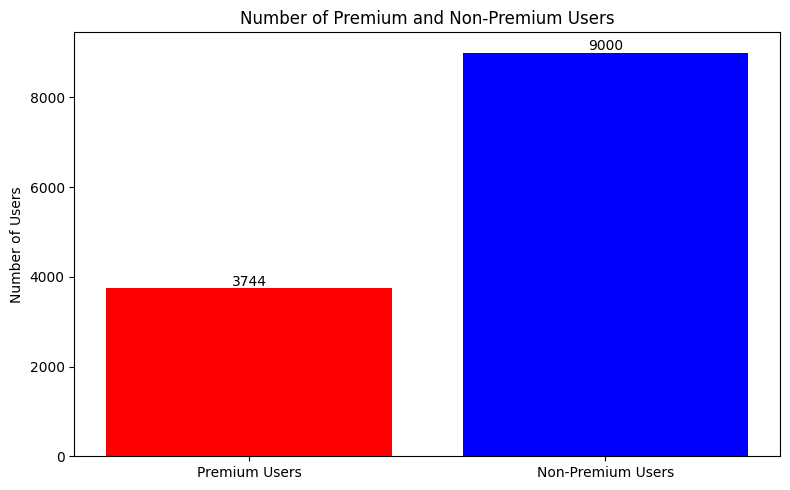

In [50]:
total_premium_users = sum(value[1] for value in user_counter.values())
total_non_premium_users = sum(value[0] for value in user_counter.values())

# Przygotuj dane do wykresu
categories = ['Premium Users', 'Non-Premium Users']
user_counts = [total_premium_users, total_non_premium_users]

# Rysowanie wykresu
plt.figure(figsize=(8, 5))
plt.bar(categories, user_counts, color=['red', 'blue'])

# Dodanie opisu osi i tytułu
plt.ylabel('Number of Users')
plt.title('Number of Premium and Non-Premium Users')

# Wyświetlenie wartości na słupkach
for i, count in enumerate(user_counts):
    plt.text(i, count + 50, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


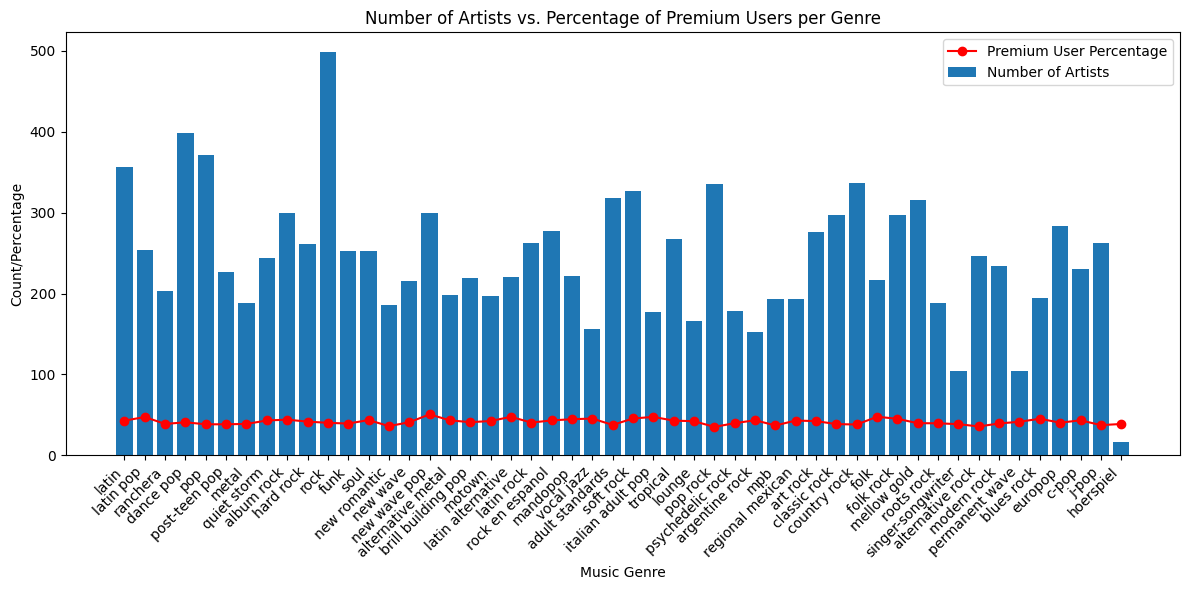

In [51]:
for genre, counts in user_counter.items():
    total_users, premium_users = counts
    user_counter[genre] = [premium_users, premium_users / total_users]

genres = list(genre_counter.keys())
gg = genres.copy()
num_bands = list(genre_counter.values())
premium_percentage = []
for genre in gg:
  if genre in user_counter:
    premium_percentage.append(user_counter[genre][1] * 100)
  else:
    num_bands.pop(genres.index(genre))
    genres.remove(genre)

plt.figure(figsize=(12, 6))
plt.bar(genres, num_bands, label='Number of Artists')
plt.plot(genres, premium_percentage, marker='o', color='red', label='Premium User Percentage')

plt.xlabel('Music Genre')
plt.ylabel('Count/Percentage')
plt.title('Number of Artists vs. Percentage of Premium Users per Genre')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
print()

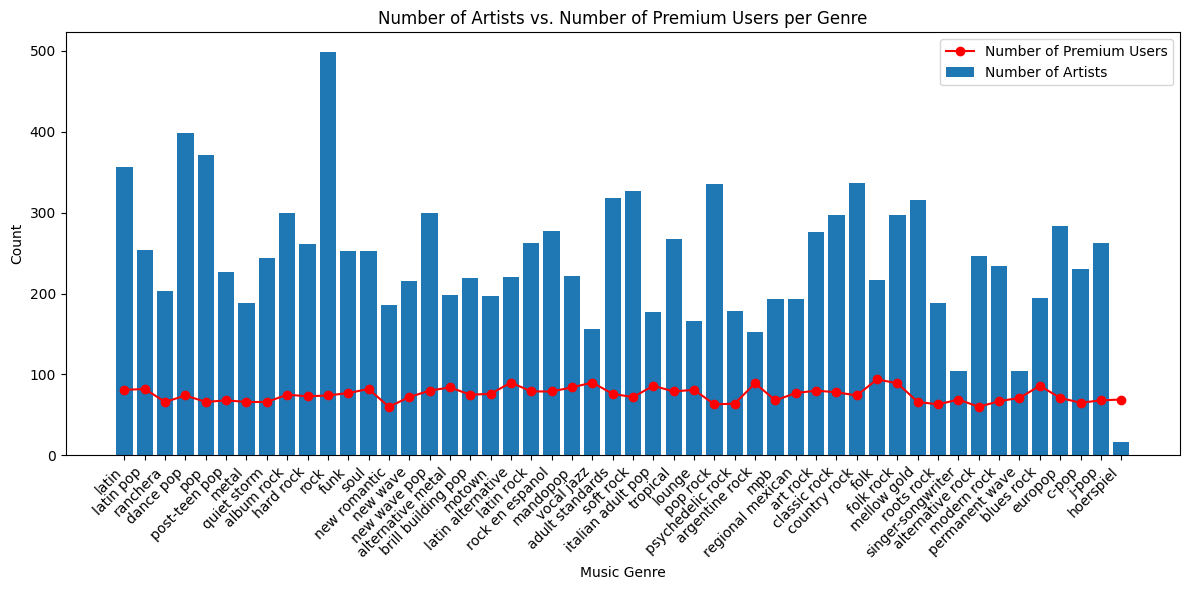

In [52]:
premium_users = [user_counter[genre][0] for genre in genres]
plt.figure(figsize=(12, 6))
plt.bar(genres, num_bands, label='Number of Artists')
plt.plot(genres, premium_users, marker='o', color='red', label='Number of Premium Users')

plt.xlabel('Music Genre')
plt.ylabel('Count')
plt.title('Number of Artists vs. Number of Premium Users per Genre')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

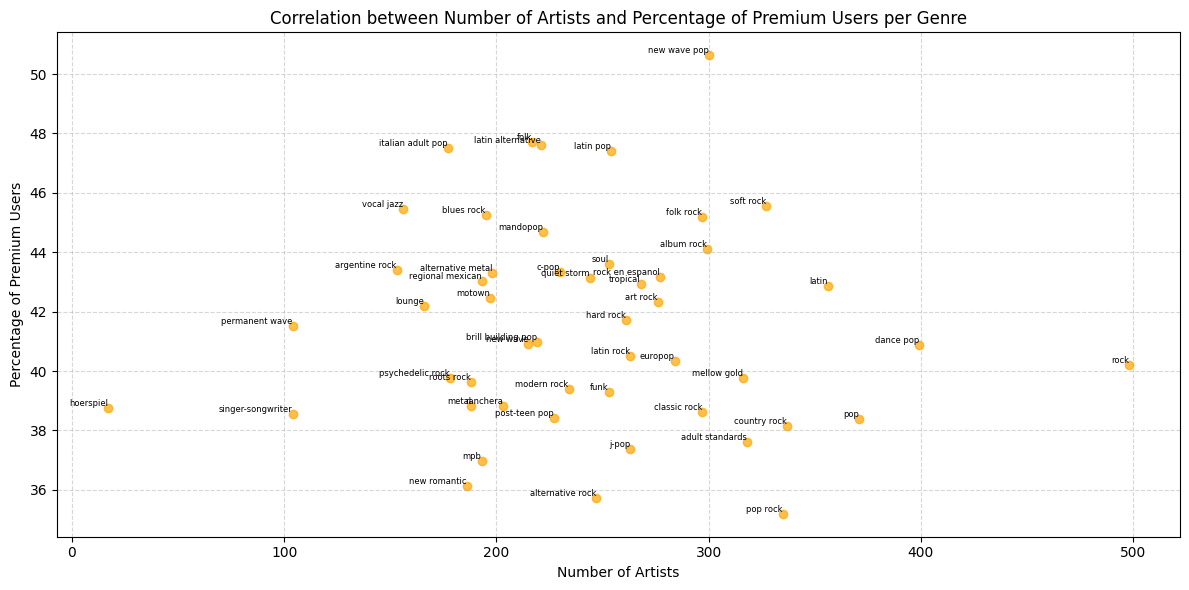

In [53]:
plt.figure(figsize=(12, 6))
plt.scatter(num_bands, premium_percentage, color='orange', alpha=0.7)

for i, genre in enumerate(genres):
    if genre in user_counter:
        plt.text(num_bands[i], premium_percentage[i], genre, fontsize=6, ha='right', va='bottom')

plt.xlabel('Number of Artists')
plt.ylabel('Percentage of Premium Users')
plt.title('Correlation between Number of Artists and Percentage of Premium Users per Genre')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [54]:
#raczej nieprzydatne ale fajnie wygląda
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim

cities = {}
for user in users:
  city = user.get('city')
  if city not in cities:
    cities[city] = [cities.get(city, 0) + 1, 1 if user.get('premium_user') else 0]
  else:
    cities[city][0] += 1
    cities[city][1] += 1 if user.get('premium_user') else 0

geolocator = Nominatim(user_agent="geoapi")

locations = []
for city, users in cities.items():
    location = geolocator.geocode(city + ", Poland")
    if location:
        locations.append((location.latitude, location.longitude, users[0]))

m = folium.Map(location=[52.237049, 21.017532], zoom_start=6)  # Centrum Polski

heat_data = [(lat, lon, count) for lat, lon, count in locations]
HeatMap(heat_data).add_to(m)
# m.save("poland_heatmap.html")

m


<Figure size 1000x500 with 0 Axes>

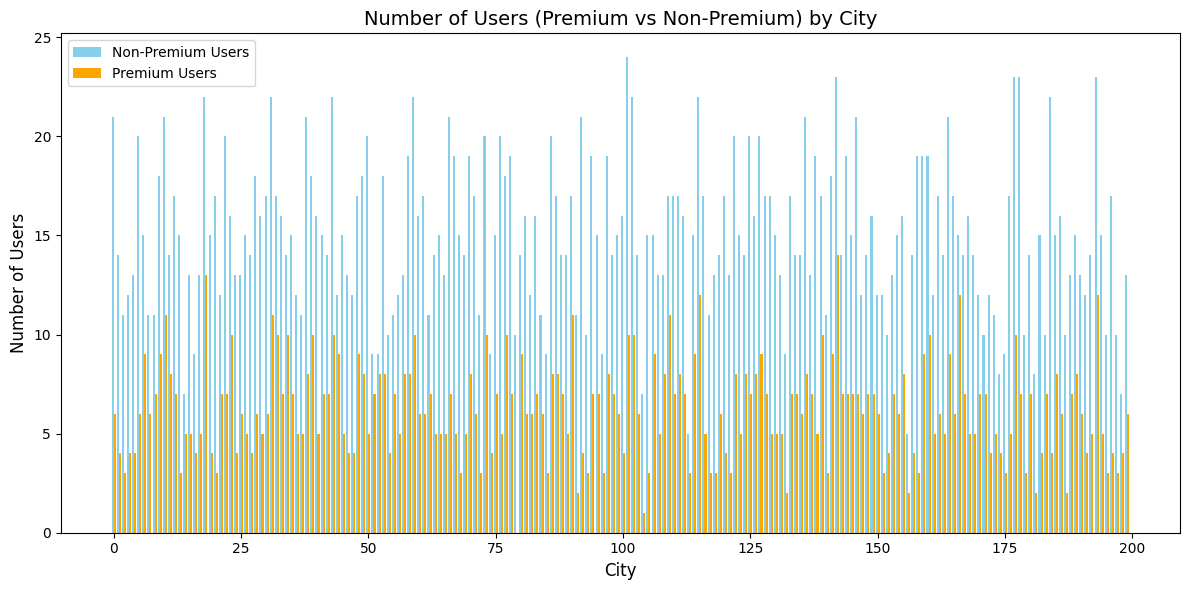

In [55]:
plt.figure(figsize=(10, 5))
keys = list(cities.keys())
values = [value[0] for value in cities.values()]
premium = [value[1] for value in cities.values()]


x = np.arange(len(keys))
bar_width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, values, width=bar_width, color='skyblue', label='Non-Premium Users')
plt.bar(x + bar_width / 2, premium, width=bar_width, color='orange', label='Premium Users')
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('Number of Users (Premium vs Non-Premium) by City', fontsize=14)

# plt.xticks(x, keys, rotation=90, ha='right', fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()
